# Tutorial 6.3. Advanced Topics on Extreme Value Analysis

### Description: Some advanced topics on Extreme Value Analysis are presented.

#### Students are advised to complete the exercises. 

Project: Structural Wind Engineering WS20-21 
        Chair of Structural Analysis @ TUM - R. Wüchner, M. Péntek, A. Kodakkal
        
Author: anoop.kodakkal@tum.de, mate.pentek@tum.de

Created on:  24.12.2019

Last update: 15.01.2021

##### Contents:

 1. Prediction of the extreme value of a time series - MaxMin Estimation 
 2. Lieblein's BLUE method
 
The worksheet is based on the knowledge base and scripts provided by [NIST](https://www.itl.nist.gov/div898/winds/overview.htm) as well as work available from [Christopher Howlett](https://github.com/chowlet5) from UWO. 

In [1]:
# import
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r as gumbel
from ipywidgets import interactive
#external files 
from peakpressure import maxminest
from blue4pressure import *
import custom_utilities as c_utils

## 1. Prediction of the extreme value of a time series - MaxMin Estimation


#### This method is based on [the procedure (and sample Matlab file](https://www.itl.nist.gov/div898/winds/peakest_files/peakest.htm) by  Sadek, F. and Simiu, E. (2002). "Peak non-gaussian wind effects for database-assisted low-rise building design." Journal of Engineering Mechanics, 128(5), 530-539. Please find it [here](https://www.itl.nist.gov/div898/winds/pdf_files/b02030.pdf).

The method uses
* gamma distribution for estimating the peaks corresponding to the longer tail of time series 
* normal distribution for estimating the peaks corresponding to the shorter tail of time series
The distribution of the peaks is then estimated by using the standard translation processes approach.


#### implementation details : 

INPUT ARGUMENTS:

Each row of *record* is a time series.
The optional input argument *dur_ratio* allows peaks to be estimated for
a duration that differs from the duration of the record itself:
   *dur_ratio* = [duration for peak estimation]/[duration of record]
   (If unspecified, a value of 1 is used.)

OUTPUT ARGUMENTS:

* *max_est* gives the expected maximum values of each row of *record*
* *min_est* gives the expected minimum values of each row of *record*
* *max_std* gives the standard deviations of the maximum value for each row of *record*
* *min_std* gives the standard deviations of the minimum value for each row of *record*


#### Let us test the method for a given time series 

In [3]:
# using as sample input some pre-generated generalized extreme value random series
given_series = np.loadtxt('test_data_gevrnd.dat', skiprows=0, usecols = (0,))

# print results
dur_ratio = 1
result = maxminest(given_series, dur_ratio = dur_ratio)
maxv = result[0][0][0]
minv = result[1][0][0]
print('estimation of maximum value ', np.around(maxv,3))
print('estimation of minimum value ', np.around(minv,3))


estimation of maximum value  2.24
estimation of minimum value  -0.675


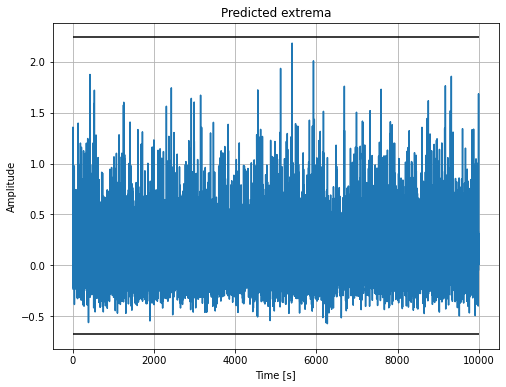

In [4]:
plt.figure(num=1, figsize=(8, 6))
x_series = np.arange(0.0, len(given_series), 1.0)
plt.plot(x_series, given_series)
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.hlines([maxv, minv], x_series[0], x_series[-1])
plt.title('Predicted extrema')
plt.grid(True)
plt.show()



#### Let us plot the pdf and cdf 

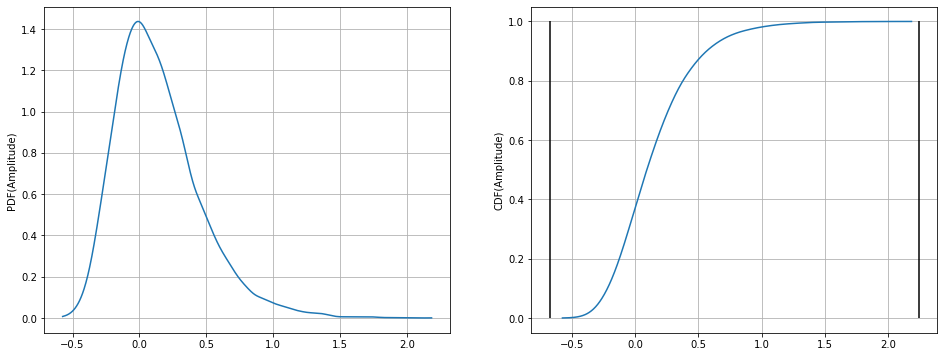

In [5]:
[pdf_x, pdf_y] = c_utils.get_pdf(given_series)
ecdf_y = c_utils.get_ecdf(pdf_x, pdf_y)
plt.figure(num=2, figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(pdf_x, pdf_y)
plt.ylabel('PDF(Amplitude)')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(pdf_x, ecdf_y)
plt.vlines([maxv, minv], 0, 1)
plt.ylabel('CDF(Amplitude)')
plt.grid(True)
plt.show()

## 2. Lieblein's BLUE method

From a time series of pressure coefficients, *blue4pressure.py* estimates
extremes of positive and negative pressures based on Lieblein's BLUE 
(Best Linear Unbiased Estimate) method applied to n epochs. 
Extremes are estimated for 1 and dur epochs for probabilities of non-exceedance 
P1 and P2 of the Gumbel distribution fitted to the epochal peaks.
*n* = integer, dur need not be an integer.
Written by Dat Duthinh 8_25_2015, 2_2_2016, 2_6_2017.

For further reference check out the material provided by [NIST](https://www.itl.nist.gov/div898/winds/gumbel_blue/gumbblue.htm).


Reference: 

1) Julius Lieblein "Efficient Methods of Extreme-Value
Methodology" NBSIR 74-602 OCT 1974 for n = 4:16

2) Nicholas John Cook "The designer's guide to wind loading of
building structures" part 1, British Research Establishment 1985 Table C3
pp. 321-323 for n = 17:24. Extension to n=100 by Adam Pintar Feb 12 2016.

3) INTERNATIONAL STANDARD, ISO 4354 (2009-06-01), 2nd edition, “Wind 
actions on structures,” Annex D (informative) “Aerodynamic pressure and 
force coefficients,” Geneva, Switzerland, p. 22  

#### implementation details : 

INPUT ARGUMENTS

* *series* = vector of time history (of pressure coefficients)
* *n_blokcs* = number of blocks (integer)of time series, 4 <= n <= 100
* *dur_ratio* = duration ratio of length of initial series to time for which the extremes should be computed
                [duration for peak estimation]/[duration of record]
* *P1, P2* = probabilities of non-exceedance of extremes in EV1 (Gumbel), P1 defaults to 0.80 (ISO)and P2 to 0.5704 (mean) for the Gumbel distribution . 

OUTPUT ARGUMENTS

* *suffix max* for + peaks, min for - peaks of pressure coeff.
* *p1_max* (p1_min)= extreme value of positive (negative) peaks with probability of non-exceedance P1 for 1 block
* *p2_max* (p2_min)= extreme value of positive (negative) peaks with probability of exceedance P2 for 1 block
* *p1_rmax* (p1_rmin)= extreme value of positive (negative) peaks with probability of non-exceedance P1 for dur blocks
* *p2_rmax* (p2_rmin)= extreme value of positive (negative) peaks with probability of non-exceedance P2 for for dur blocks
* *series_max* (series_min)= vector of n positive (negative) epochal peaks
* *u_max, b_max* (u_min, b_min) = location and scale parameters of EV1 (Gumbel) for positive (negative) peaks

In [4]:
# n = number of epochs (integer)of cp data, 4 <= n <= 100
n=4
# P1, P2 = probabilities of non-exceedance of extremes in EV1 (Gumbel).
P1=0.80
P2=0.5704 # this corresponds to the mean of gumbel distribution  
# dur = number of epochs for estimation of extremes. Default dur = n
# dur need not be an integer
dur=1

# Call function
result = blue4pressure(given_series, n, P1, P2, dur)
p1_max = result[0][0]
p2_max = result[1][0]
umax = result[4][0] # location parameters
b_max = result[5][0] # sclae parameters 
p1_min = result[7][0]
p2_min = result[8][0]
umin = result[11][0] # location parameters 
b_min = result[12][0] # scale parameters 

In [5]:
# print results
## maximum 
print('estimation of maximum value with probability of non excedence of p1', np.around(p1_max,3))
print('estimation of maximum value with probability of non excedence of p2', np.around(p2_max,3))
## minimum 
print('estimation of minimum value with probability of non excedence of p1', np.around(p1_min,3))
print('estimation of minimum value with probability of non excedence of p2', np.around(p2_min,3))

estimation of maximum value with probability of non excedence of p1 2.055
estimation of maximum value with probability of non excedence of p2 1.908
estimation of minimum value with probability of non excedence of p1 -0.582
estimation of minimum value with probability of non excedence of p2 -0.547


#### Let us plot the pdf and cdf for the maximum values

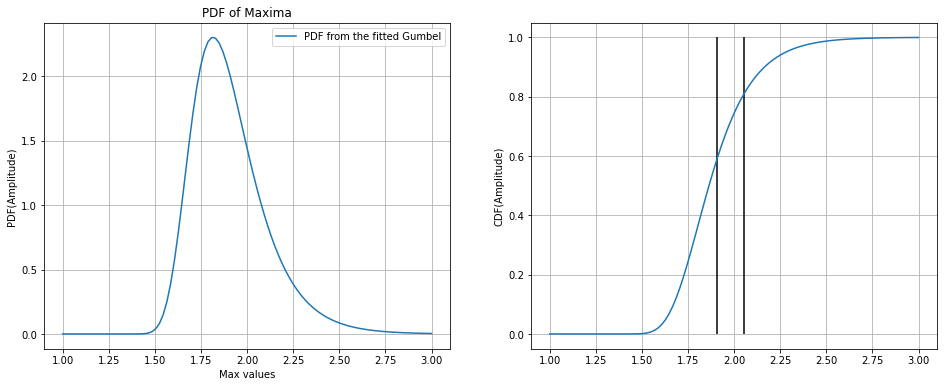

In [6]:
max_pdf_x = np.linspace(1, 3, 100)
max_pdf_y = gumbel.pdf(max_pdf_x, umax, b_max)
max_ecdf_y = c_utils.get_ecdf(max_pdf_x, max_pdf_y)

plt.figure(num=3, figsize=(16, 6))
plt.subplot(1,2,1)
# PDF generated as a fitted curve using generalized extreme distribution
plt.plot(max_pdf_x, max_pdf_y, label = 'PDF from the fitted Gumbel')
plt.xlabel('Max values')
plt.ylabel('PDF(Amplitude)')
plt.title('PDF of Maxima')
plt.grid(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(max_pdf_x, max_ecdf_y)
plt.vlines([p1_max, p2_max], 0, 1)
plt.ylabel('CDF(Amplitude)')
plt.grid(True)
plt.show()

#### Try plotting these for the minimum values. Discuss among groups the advanced extreme value evaluation methods.